In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[19]:


# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import numpy as np


# In[67]:


from pydatastream import Datastream
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from datetime import date, timedelta


# In[4]:


dl = DataLib("SignalData")


# In[6]:


LongRates = dl.pull('LongRates')
ShortRates = dl.pull('ShortRates')
BondReturnIndex = dl.pull('BondRetIdx/LocalFX')


# In[ ]:





# # Indicators

# #### 1. Money Supply (M1, M2, and/or M3 [for US])
#     

# #### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Claim: 
# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Growth in the monetary base over the past X months compared to the past 1 year is indicative of a higher propensity for increased inflation. The inflation &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; will erode returns of bonds and lead to raised interest rates. 

# #### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Parameters to test: 
# <br>
#     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Type of Money Supply: M1, M2, M3
#     <br>
#     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Countries
#     <br>
#     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Size of window to determine growth of monetary base: 3 months, 6 months, 9 months

# #### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Considerations: 
# <br>
#     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Industrial production
#     <br>
#     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Spending
#     <br>
#     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Consumer/producer price index

# #### 2.

# In[ ]:





# In[ ]:





# In[786]:


BondReturnIndex = dl.pull('BondRetIdx/LocalFX')["USA"]
BondReturnIndex


# In[ ]:





# In[ ]:





# In[803]:


#returns time-series data of daily, cumulative profits/losses
def pnl_series(signals, bankroll, country, start=0, end=0):
    
    #if signals data is monthly and not daily
    BondReturnIndex = dl.pull('BondRetIdx/LocalFX')[country]
    BondReturnIndex = BondReturnIndex.to_frame("return")

    BondReturnIndex["daily_change"] = np.exp(np.log(BondReturnIndex["return"]).diff(1))
    BondReturnIndex["full-date"] = BondReturnIndex.index.to_series().astype(str)
    BondReturnIndex["year-month"] = BondReturnIndex['full-date'].str.slice(0, 7)

    merged = BondReturnIndex.set_index("year-month").join(signals[['year-month', "signal"]].set_index("year-month"), on="year-month", how='left', lsuffix="-og")
    merged["signal"] = merged["signal"].shift(1)

    merged['net_for_day'] = merged['signal'] * (merged['daily_change']-1) * bankroll #calculation
    merged = merged.set_index("full-date")
    
    cumulative = merged["net_for_day"].cumsum()

    return cumulative, merged

#plots PNL vs BondReturnIndex
def plot_pnl(pnl_values, indicator, country):
    pnl_values = pnl_values.to_frame().set_index(pd.to_datetime(pnl_values.index))
    
    fig, ax1 = plt.subplots()
    ax1_label = 'Profit and Loss'
    ax1.plot(pnl_values, label = indicator)
    ax1.set_ylabel(ax1_label)
    ax1.plot(BondReturnIndex.to_timestamp(), color = 'tab:red', label = "Bond Return Index")
    ax1.legend()
    plt.title("{0} vs Bond Return Index".format(indicator+" " + country))
    plt.show()    

    
#use later - plotting in general
def plot(item, start=0, end=0, countries=0):
    ticker = dl.pull(item)
    selected = 0
    if start and end:
        if not countries:
            selected = ticker.loc[pd.Period(start):pd.Period(end)]
        else:
            selected = ticker.loc[pd.Period(start):pd.Period(end), countries]
    else:
        if not countries:
            selected = ticker
        else:
            selected = ticker[countries]
    selected.plot()
    

class Indicator:
    #returns time series data from -1 to 1, for each day from "start" to "end" of the decision based on monetary supply
    
    def __init__(self, country, weights):
        self.country = country
        self.weights = weights
    
    def monetary_supply_indicator(self, m):
        m2 = dl.pull(m+"/inUSD")[self.country]
        m2 = m2.to_frame("supply")
        
        m2["year-month"] = m2.index.to_series().astype(str)
        m2["diff_3"] = np.exp(np.log(m2["supply"]).diff(3))
        m2["diff_12"] = np.exp(np.log(m2["supply"]).diff(12))
        m2["signal"] = np.where(m2['diff_12'] < m2['diff_3'], -1, 1)
        return m2
    
    def always_constant(self, m,x):
        m2 = dl.pull(m+"/inUSD")[self.country]
        m2 = m2.to_frame("supply")
        
        m2["year-month"] = m2.index.to_series().astype(str)
        m2["diff_3"] = np.exp(np.log(m2["supply"]).diff(3))
        m2["diff_12"] = np.exp(np.log(m2["supply"]).diff(12))
        m2["signal"] = x
        return m2

    #use later to combine MULTIPLE indicators
    def signals(self,selected_indicators):
        indicators = selected_indicators()
        final_signals = []

        for day in all_dates:
            final_signal = 0
            for i in range(1):
                final_signal = indicators[i]*self.weights[i]
            final_signals.append(final_signal)

        return final_signals



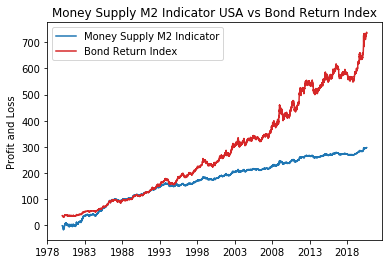

In [3]:

a = Indicator("USA", [1])
signals = a.monetary_supply_indicator("M2")
pnl_values, table = pnl_series(signals, 100, "USA")
plot_pnl(pnl_values, "Money Supply M2 Indicator", "USA")